# Reddit Data Influencer Score Fitting 
- fit fake sentiment 
- cluster senitment 
- fit influencer score

In [171]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling 

# Fitting Fake Sentiment 

In [9]:
# Reddit Script 
#### imports ####

import praw
import pandas as pd
from datetime import datetime
from praw.models import MoreComments
import preprocessor as pre
import regex as re


reddit = praw.Reddit(
    client_id="auD_kIwyQ1r3hfxTQEYuGw",
    client_secret="XyLGeMB1mJqoaB0lCXrk4Jtmy515AA",
    password="wisdmai1234",
    user_agent="wisdm",
    username="Dramatic-Ad-9651",
    check_for_async=False
)

# make sure we're connected to the api
print(reddit.user.me())


#### Data Extraction #### 

posts = pd.DataFrame()
comments = pd.DataFrame()

tickers = tickers = list(set(['SPY','TSLA','PYPL', 'GME', 'VIX', 'AMD', 'F',
                              'BBBY', 'NFLX', 'NVDA', 'AAPL', 'INTC', 'FSR', 
                              'QQQ', 'TLRY', 'MSFT', 'TWTR', 'SNAP', 'HOOD', 
                              'WMT', 'PTON', 'WISH', 'CPRX', 'AMC', 'SNDL', 
                              'AMZN', 'DIS', 'NIO', 'FB', 'NFLX', 'LCID', 'NVDA']))


subreddits = ['wallstreetbets', 'stocks',  'investing', 'finance']


for ticker in tickers: 
    for sub in subreddits: 
        subreddit = reddit.subreddit(sub)
        print(subreddit, ' - ', ticker)
        for post in subreddit.search(ticker.lower(), sort = 'new', time_filter = 'day', limit = None):
            #check if title has stock ticker 
            if ticker.lower() not in post.title.lower(): 
                #print(post.title)
                continue 
            #check if author is not banned 
            if hasattr(post.author, 'is_suspended'):
                #print(post.author.is_suspended)
                continue
            try: 
                #collect desired values 
                title_instance = {
                    'ticker': ticker, 
                    'subreddit': str(post.subreddit),
                    'content': post.title, 
                    'upvotes': post.score, 
                    'upvote_ratio': post.upvote_ratio,
                    'num_comments': post.num_comments, 
                    #might break in author deletes their post 
                    'author_comment_karma': post.author.comment_karma, 
                    'author_verified': post.author.has_verified_email, 
                    'time': datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d'),
                }
            
            except: 
                continue 

            #create row and concat it to the df
            row = pd.DataFrame([title_instance])
            posts = pd.concat([posts, row], axis = 0, ignore_index = True)

            #checking comments
            for comment in post.comments:
                #do not want sub comments of comments 
                if isinstance(comment, MoreComments):
                    continue
                #remove user reports
                if 'user report' in comment.body.lower(): 
                    continue
                
                try: 
                    comment_instance = {
                        'ticker': ticker, 
                        'subreddit': str(post.subreddit), 
                        # optional can remove if no grouping by title is needed 
                        'post_title': post.title,
                        'content': comment.body, 
                        'upvotes': comment.score, 
                        'replies': comment.replies.__len__(), 
                        'sticked': comment.stickied,
                        #might break deleted comments
                        'author_comment_karma': comment.author.comment_karma, 
                        'author_verified': comment.author.has_verified_email, 
                        'time': datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d'),
                    }
                except:
                    continue

                row = pd.DataFrame([comment_instance])
                comments = pd.concat([comments, row], axis = 0, ignore_index = True)


#### Data Export #### 


comments_df = comments.copy()
posts_df = posts.copy()




#comments_export_path = r"C:\Users\Dennis\Desktop\comments.csv"
#comments_df.to_csv(comments_export_path)

#posts_export_path = r"C:\Users\Dennis\Desktop\posts.csv"
#posts_df.to_csv(posts_export_path)

print('Data Exported')
print("Posts", len(posts_df))
print("Comments:", len(comments_df))

Version 7.6.0 of praw is outdated. Version 7.6.1 was released 2 days ago.


Dramatic-Ad-9651
wallstreetbets  -  CPRX
stocks  -  CPRX
investing  -  CPRX
finance  -  CPRX
wallstreetbets  -  NFLX
stocks  -  NFLX
investing  -  NFLX
finance  -  NFLX
wallstreetbets  -  SPY
stocks  -  SPY
investing  -  SPY
finance  -  SPY
wallstreetbets  -  SNAP
stocks  -  SNAP
investing  -  SNAP
finance  -  SNAP
wallstreetbets  -  VIX
stocks  -  VIX
investing  -  VIX
finance  -  VIX
wallstreetbets  -  GME
stocks  -  GME
investing  -  GME
finance  -  GME
wallstreetbets  -  PYPL
stocks  -  PYPL
investing  -  PYPL
finance  -  PYPL
wallstreetbets  -  TWTR
stocks  -  TWTR
investing  -  TWTR
finance  -  TWTR
wallstreetbets  -  WISH
stocks  -  WISH
investing  -  WISH
finance  -  WISH
wallstreetbets  -  AMZN
stocks  -  AMZN
investing  -  AMZN
finance  -  AMZN
wallstreetbets  -  FSR
stocks  -  FSR
investing  -  FSR
finance  -  FSR
wallstreetbets  -  TSLA
stocks  -  TSLA
investing  -  TSLA
finance  -  TSLA
wallstreetbets  -  NIO
stocks  -  NIO
investing  -  NIO
finance  -  NIO
wallstreetbets 

In [10]:
comments_df.shape

(378, 10)

In [11]:
comments.head()

,ticker,subreddit,post_title,content,upvotes,replies,sticked,author_comment_karma,author_verified,time
0,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,"No fucking way!!! Omfg, the algos will be hedg...",47,2,False,29668,True,2022-11-13
1,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,Calls on gain porn. And loss porn.,28,0,False,558,False,2022-11-13
2,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,Now I can sell SPY/QQQ spreads to regards ever...,22,0,False,4087,True,2022-11-13
3,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,I keep looking for the blue checkmark to see i...,21,0,False,1940,True,2022-11-13
4,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,Let the real casino begin.,16,1,False,1322,True,2022-11-13


In [12]:
sentiments = ['neutral', 'negative', 'positive']


In [13]:
analyser = SentimentIntensityAnalyzer()

In [14]:
text = comments['content'].values[0]
text

'No fucking way!!! Omfg, the algos will be hedging insane ups and downs on 0dte with 1dte....\n\nThis is so criminal, guess we are gonna see some big balls volatility coming up'

In [15]:
type(text)

str

In [16]:
results = analyser.polarity_scores(text)
results

{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.8791}

In [17]:
del results['compound'] 
results

{'neg': 0.259, 'neu': 0.741, 'pos': 0.0}

In [18]:
max(results, key = results.get)

'neu'

In [19]:
results[max(results, key = results.get)]

0.741

In [20]:
def add_sentiment(df): 
    content = df['content'].copy().values 
    sentiments, scores = [], []
    for text in content:
        results = analyser.polarity_scores(text)
        del results['compound'] 

        sentiment = max(results, key = results.get) 
        score = results[sentiment]  

        sentiments = np.append(sentiments, sentiment) 
        scores = np.append(scores, score)

    new_df = df.copy() 
    new_df['sentiment'] = sentiments 
    new_df['sentiment_pscore'] = scores 

    return new_df

In [21]:
sentiment_df = add_sentiment(comments_df)

In [22]:
sentiment_df.head()

,ticker,subreddit,post_title,content,upvotes,replies,sticked,author_comment_karma,author_verified,time,sentiment,sentiment_pscore
0,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,"No fucking way!!! Omfg, the algos will be hedg...",47,2,False,29668,True,2022-11-13,neu,0.741
1,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,Calls on gain porn. And loss porn.,28,0,False,558,False,2022-11-13,neu,0.467
2,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,Now I can sell SPY/QQQ spreads to regards ever...,22,0,False,4087,True,2022-11-13,neu,0.760
3,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,I keep looking for the blue checkmark to see i...,21,0,False,1940,True,2022-11-13,neu,1.000
4,SPY,wallstreetbets,CBOE to add Spy and QQQ options on Tuesday and...,Let the real casino begin.,16,1,False,1322,True,2022-11-13,neu,1.000


# Feature Engineering

In [25]:
# to do


# Simple Clustering

In [56]:
cluster_df = sentiment_df[['sentiment_pscore', 'upvotes', 'replies', 'upvotes', 'author_comment_karma']].copy()
cluster_df.head()

,sentiment_pscore,upvotes,replies,upvotes,author_comment_karma
0,0.741,47,2,47,29668
1,0.467,28,0,28,558
2,0.760,22,0,22,4087
3,1.000,21,0,21,1940
4,1.000,16,1,16,1322


In [117]:
kmeans = KMeans(n_clusters= 2, random_state = 11) 

In [118]:
kmeans.fit(cluster_df)

KMeans(n_clusters=2, random_state=11)

In [119]:
labels = kmeans.labels_

In [120]:
centers = kmeans.cluster_centers_
centers

array([[8.18775000e-01, 9.25000000e+00, 4.19444444e-01, 9.25000000e+00,
        1.31454333e+04],
       [8.01000000e-01, 1.62222222e+01, 1.16666667e+00, 1.62222222e+01,
        2.98570000e+05]])

In [ ]:
#reduce the dimension 5 to 2 dimensions to vizualise the dataset 
data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(cluster_df.to_numpy())

In [173]:
kmeans.fit(data_embed)
labels = kmeans.labels_

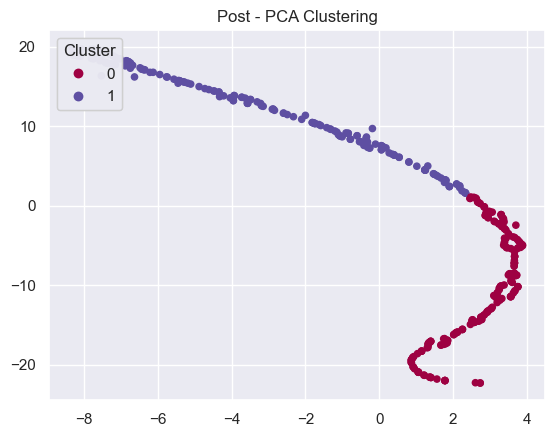

In [174]:
clusters = ['Cluster 1', 'Cluster 2']
x, y = data_embed[:, 0], data_embed[:, 1]


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=labels, s=20 ,cmap="Spectral")

legend = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Cluster")

ax.add_artist(legend)
plt.title("Post - PCA Clustering");


# Clustering w/ Additional Features 

In [180]:
dummies = pd.get_dummies(data = sentiment_df, columns = ['ticker', 'subreddit', 'sticked', 'author_verified', 'sentiment'])
dummies.columns

Index(['post_title', 'content', 'upvotes', 'replies', 'author_comment_karma',
       'time', 'sentiment_pscore', 'ticker_F', 'ticker_NIO', 'ticker_QQQ',
       'ticker_SNAP', 'ticker_SPY', 'ticker_TSLA', 'subreddit_stocks',
       'subreddit_wallstreetbets', 'sticked_False', 'sticked_True',
       'author_verified_False', 'author_verified_True', 'sentiment_neg',
       'sentiment_neu', 'sentiment_pos'],
      dtype='object')

In [181]:
cluster_df = dummies.drop(['post_title', 'content', 'time', 'sticked_False', 'author_verified_False'], axis = 1)
cluster_df.head()

,upvotes,replies,author_comment_karma,sentiment_pscore,ticker_F,ticker_NIO,ticker_QQQ,ticker_SNAP,ticker_SPY,ticker_TSLA,subreddit_stocks,subreddit_wallstreetbets,sticked_True,author_verified_True,sentiment_neg,sentiment_neu,sentiment_pos
0,47,2,29668,0.741,0,0,0,0,1,0,0,1,0,1,0,1,0
1,28,0,558,0.467,0,0,0,0,1,0,0,1,0,0,0,1,0
2,22,0,4087,0.760,0,0,0,0,1,0,0,1,0,1,0,1,0
3,21,0,1940,1.000,0,0,0,0,1,0,0,1,0,1,0,1,0
4,16,1,1322,1.000,0,0,0,0,1,0,0,1,0,1,0,1,0


In [ ]:
data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(cluster_df.to_numpy())

In [184]:
kmeans = KMeans(n_clusters= 2, random_state = 11) 
kmeans.fit(data_embed)
labels = kmeans.labels_

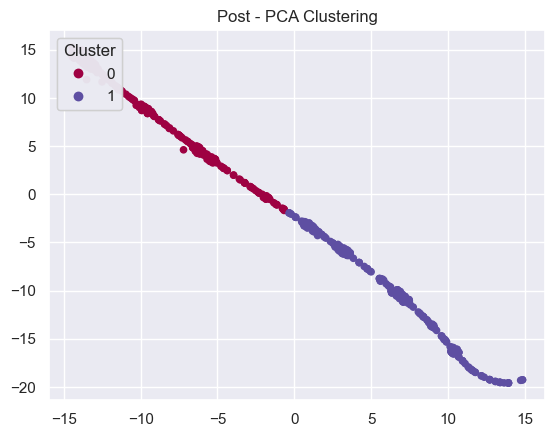

In [185]:
clusters = ['Cluster 1', 'Cluster 2']
x, y = data_embed[:, 0], data_embed[:, 1]


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=labels, s=20 ,cmap="Spectral")

legend = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Cluster")

ax.add_artist(legend)
plt.title("Post - PCA Clustering");


# Clustering w/ Normalization

In [186]:
norm_cluster_df = pd.DataFrame(normalize(cluster_df))
norm_cluster_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.001584,0.000067,0.999999,0.000025,0.0,0.0,0.0,0.0,0.000034,0.0,0.0,0.000034,0.0,0.000034,0.0,0.000034,0.0
1,0.050116,0.000000,0.998738,0.000836,0.0,0.0,0.0,0.0,0.001790,0.0,0.0,0.001790,0.0,0.000000,0.0,0.001790,0.0
2,0.005383,0.000000,0.999985,0.000186,0.0,0.0,0.0,0.0,0.000245,0.0,0.0,0.000245,0.0,0.000245,0.0,0.000245,0.0
3,0.010824,0.000000,0.999941,0.000515,0.0,0.0,0.0,0.0,0.000515,0.0,0.0,0.000515,0.0,0.000515,0.0,0.000515,0.0
4,0.012102,0.000756,0.999925,0.000756,0.0,0.0,0.0,0.0,0.000756,0.0,0.0,0.000756,0.0,0.000756,0.0,0.000756,0.0


In [ ]:
norm_data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(norm_cluster_df.to_numpy())

In [188]:
kmeans = KMeans(n_clusters= 2, random_state = 11) 
kmeans.fit(norm_data_embed)
labels = kmeans.labels_

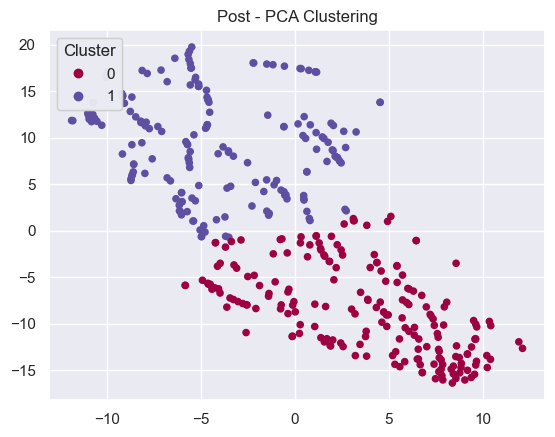

In [189]:
clusters = ['Cluster 1', 'Cluster 2']
x, y = norm_data_embed[:, 0], norm_data_embed[:, 1]


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=labels, s=20 ,cmap="Spectral")

legend = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Cluster")

ax.add_artist(legend)
plt.title("Post - PCA Clustering");
